# Density discretization (Lottery method)

#### Load packages

In [15]:
using Parameters
using Setfield
using Interpolations
using Plots

#### Set up structures

In [16]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.95
    γ :: T = 2.0
    ρ :: T = 0.95
    σ2 :: T = 0.02
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 200 # asset grid
    amin :: Float64 = 0.0 
    amax :: Float64 = 50.0 
    ny   :: Int = 5 # income grid
    tol_pol :: Float64 = 1e-7
    tol_density :: Float64 = 1e-10
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)       # transition matrix income
    gridY :: Array{Float64,1} = zeros(n_par.ny)   # income grid
end

Grids

#### Discretization

In [17]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM

In [18]:
function egm(r, rprime, w, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, gV_conHA::ContainerHA)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    @unpack_ContainerHA gV_conHA

    Ai= copy(A)
    difference= 1000.0
    it=0
    Uc= zeros(na,ny)

    while difference > tol_pol && it < 1000

        for y in 1:ny
            Uc[:,y]= ( (1+rprime)*gridA .+ w*gridY[y] .- A[:,y] ).^(-γ)
        end
        EUc= Uc * Π' # expectation (* is matrix multiplication)
        RHS= β * (1+r) .* EUc # RHS of Euler
        for y in 1:ny
            Cendog= RHS[:,y].^(-1/γ)
            Aendog= (gridA .+ Cendog .- w*gridY[y]) ./ (1 + r)
            itp= LinearInterpolation(Aendog, gridA, extrapolation_bc=Line())
            Ai[:,y]= itp.(gridA)
        end        
        Ai[Ai.<=amin] .= amin # set borrowing constraint
        difference= maximum(abs.(A .- Ai))
        A= copy(Ai)

        it= it+1

    end 

    # Asset policy function
    for y in 1:ny
        C[:,y]= (1+r).*gridA .+ w*gridY[y] .- A[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C)

    println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

## Density discretization

Let's assume we solved for the policy functions via the EGM method. We now want to compute/approximate the invariant distribution over assets. 

Denote the asset policy function by $g(a,y)$. Denote the invariant density function we want to approximate by $\lambda(a,y)$. We will approximate this density by a pdf defined over a discretized version of the state space.

- Create an initial guess for the density. For instance a uniform one. 

- For every $(a_k, y_j)$ on the grid compute 
\begin{align*}
\lambda^1(a_k,y_j) &= \sum_{y_i} \Gamma(y_j|y_i) \sum_{m \in \mathcal{M}_i} \frac{a_{k+1} - g(a_m,y_i)}{a_{k+1} - a_k} \lambda^0(a_m, y_i) \\
\lambda^1(a_{k+1},y_j) &= \sum_{y_i} \Gamma(y_j|y_i) \sum_{m \in \mathcal{M}_i} \frac{g(a_m,y_i) - a_k}{a_{k+1} - a_k} \lambda^0(a_m, y_i),
\end{align*}
where $\mathcal{M} = \{ m= 1,...,N | a_k \leq g(a_m,y_i) \leq a_{k+1} \}$; that is for every $y_i$, it is the set of all asset policies that are bracketed by the grid points $a_k$ and $a_{k+1}$. 

- Iterate on the above until convergence. 

The discretization above essentially entails agents playing a lottery. For an agent with policy $a' = g(a_m, y_i) \in [a_k, a_{k+1}]$, she is going with probability $\frac{a_{k+1} - g(a_m,y_i)}{a_{k+1} - a_k}$ to gridpoint $a_k$ and with probability $\frac{g(a_m,y_i) - a_k}{a_{k+1} - a_k}$ she is going to gridpoint $a_{k+1}$. For instance, if an agent's asset policy is exactly in the middle between two gridpoints, she will go to either with equal probability. The mass of agents of type $i$ that play the same lottery is given by $\lambda^0(a_m, y_i)$. Summing over all types $i$ gives the total mass that moves to $\lambda(a_k,y_j)$ and $\lambda(a_{k+1},y_j)$, respectively.  

Note: In the code below, I call the fractions above "weight" and "1-weight", and the combination of fraction and mass of agents "lottery". 

Having computed the density compute aggregate assets as
\begin{align}
 A = \sum_{y} \sum_{a} a \lambda(a,y)
\end{align}



In [19]:
function density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters,A_dist)

    # Unpack
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    
    # retrieve indices and weights for lottery
    A_indices= zeros(Int, na, ny) 
    wei= zeros(Float64,na,ny) 

    for y in 1:ny
        # Indices
        A_indices[:,y] = searchsortedlast.(Ref(gridA), gV_conHA.A[:,y])  # gives left bracket; 0 if below grid, na if above grid
    end
    A_indices[A_indices .== 0] .= 1
    A_indices[A_indices .== na] .= na-1
    for y in 1:ny
        wei[:,y]= (gV_conHA.A[:,y] .- [gridA[i] for i in A_indices[:,y]]) ./ ([gridA[i+1] for i in A_indices[:,y]] .- [gridA[i] for i in A_indices[:,y]])
    end
    # should never be binding, but just to be save
    wei[wei.>1] .=1
    wei[wei.<0] .=0


    
    difference= 100.0
    it=1
    # iterate over discretized density to get fixed point
    while difference > tol_density && it < 10000
    
        # always pre-allocate to zero
        A_disti= zeros(Float64,na,ny) 

        for i in 1:na
            for s in 1:ny
                index= A_indices[i,s]
                lottery1= (1-wei[i,s]) * A_dist[i,s]
                lottery2= wei[i,s]* A_dist[i,s]
                for si in 1:ny
                    A_disti[index,si] += lottery1 * Π[s,si]
                    A_disti[index + 1,si] += lottery2 * Π[s,si] 
                end
            end
        end

        difference= maximum(abs.(A_disti .- A_dist))
        A_dist= A_disti ./ sum(A_disti)
        it= it+1

    end

    it == 10000 ? println("density_discretization did not converge") : Nothing

    return A_dist

end

density_discretization (generic function with 1 method)

#### Initialize

In [20]:
m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();

lnincomeGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
incomeGrid= exp.(lnincomeGrid)

gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
grids= Grids(gridA=gridA, Π=transitionMatrix, gridY=incomeGrid);

#### Illustration

In [21]:
# Interest rate
r= 0.03
# Wage
w= 1.0


# Guess
Cguess= ones(n_par.na, n_par.ny) .* r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);

# EGM
gV_conHA= egm(r, r, w, m_par, n_par, grids, gV_conHA);

Finished EGM in iteration = 210, and diff = 9.998442607184188e-8


In [22]:
# Density discretization
mA_Dist= ones(n_par.na, n_par.ny)/(n_par.na*n_par.ny);
mA_Dist= density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters, mA_Dist)
vA_dist= sum(mA_Dist,dims=2)

## Aggregate assets
println("Aggregate assets = ", sum(vA_dist .* grids.gridA))


Aggregate assets = 3.4264687264822458


#### Plot distribution

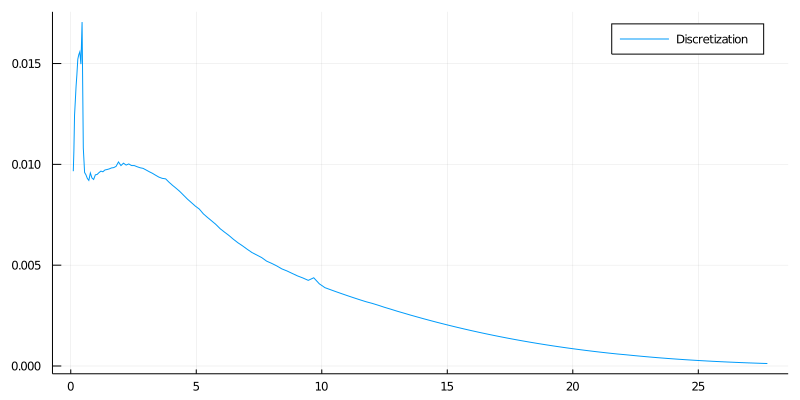

In [23]:
plot(grids.gridA[10:150], vA_dist[10:150], label="Discretization")
plot!(size=(800,400))